In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lung-section-category/category/lung(upper)/lung(upper) (81).png
/kaggle/input/lung-section-category/category/lung(upper)/lung(upper) (175).png
/kaggle/input/lung-section-category/category/lung(upper)/lung(upper) (205).png
/kaggle/input/lung-section-category/category/lung(upper)/lung(upper) (123).png
/kaggle/input/lung-section-category/category/lung(upper)/lung(upper) (23).png
/kaggle/input/lung-section-category/category/lung(upper)/lung(upper) (261).png
/kaggle/input/lung-section-category/category/lung(upper)/lung(upper) (238).png
/kaggle/input/lung-section-category/category/lung(upper)/lung(upper) (61).png
/kaggle/input/lung-section-category/category/lung(upper)/lung(upper) (245).png
/kaggle/input/lung-section-category/category/lung(upper)/lung(upper) (262).png
/kaggle/input/lung-section-category/category/lung(upper)/lung(upper) (94).png
/kaggle/input/lung-section-category/category/lung(upper)/lung(upper) (62).png
/kaggle/input/lung-section-category/category/lung(upper)/

In [6]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

In [7]:
epochs = 10 #訓練的次數

img_rows = None #影像檔的高
img_cols = None #影像檔的寬

x_list = list() #存所有影像的array
y_list = list() #存所有名稱的array
x_train = list()
y_train = list()
x_test = list()
y_teat = list()

In [8]:
path = '../input/lung-section-category/category/'

folder_filenames = os.listdir(path) #列出該路徑下的資料夾(此為分類項目)
print(folder_filenames)

i = 0
for folder_filename in folder_filenames:
    for img_filename in os.listdir(path + folder_filename):
        if '.png' not in img_filename:
            continue
        img = load_img((path + folder_filename + '/{0}').format(img_filename, color_mode = 'grayscale'))
        img = img.convert('L') #轉成灰度圖
        img_array = img_to_array(img) #將numpy矩陣中的整數轉換成浮點數

        #n = img_array[464:976, 704:1216]
        n = img_array
        n = (n - np.min(n)) / (np.max(n) - np.min(n)) #歸一化
        
        #n = np.where(n > np.mean(n), 255, 0) #若n > n的平均值，輸出255，反之輸出0
        
        x_list.append(n) #放圖像資料
        y_list.append(i) #放分類資料
        
        (img_rows, img_columns ) = img_array.shape[0], img_array.shape[1]

    i = i + 1

y_list = keras.utils.to_categorical(y_list, num_classes=10) #將類別向量轉換為二進制

['lung(upper)', 'clavicle', 'lung(lower)', 'abdomen', 'upper', 'lower']


In [9]:
# 將訓練資料拆分成測試集 驗證集
x_train, x_test, y_train, y_test = train_test_split(x_list, y_list, train_size=0.75) #train_size若為None時，train_size自動設定成0.75

#轉成numpy陣列
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

'''
原本要做normalized(特徵標準化)，但最大值可能不是255
x_train = x_train  / 255
x_test = x_test / 255
'''

print(img_rows, img_columns)

print(x_train.shape) #張數(資料數), row, column, channel

512 512
(524, 512, 512, 1)


In [10]:
"""
建立模型
"""
#if os.path.isfile('cnn_model.h5'):
    #model = models.load_model('cnn_model.h5')
    #print('Model loaded from file.')
#else:
model = models.Sequential()
#建立卷積層，讓程式隨機產生32個濾鏡，每個濾鏡為3x3的大小，輸入的形狀為(寬度,長度,1)，活化函數為relu
#filters：卷積核的個數，kernel_size：卷積核的大小，strdes：步長[二維中默認為(1, 1), 一維默認為1]，Padding：補「0」策略 -> 'valid'指卷積後的大小與原來的大小可以不同, 'same'則卷積後大小與原來大小一致
model.add(layers.Conv2D(32, kernel_size=(3, 3), padding ='same', input_shape=(512, 512, 1 ), activation='relu',))
#池化層:將圖片縮小，進行縮減取樣
#pool_size：長度為2的整數tuple，表示在橫向和縱向的下採樣樣子，一維則為縱向的下採樣因子padding(與卷積層的padding相同)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#再次建立卷積層，共產生64個濾鏡，每個濾鏡為3x3的大小，輸入的形狀為(寬度,長度,1)，活化函數為relu
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
#進行縮減取樣
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#為了防止過度擬合的現象發生，隨機放棄25%的神經元。
model.add(layers.Dropout(rate=0.25))
#將多維陣列降為成一維，用於卷積層到全連接層的過度
model.add(layers.Flatten())
#全連接層:實現對神經網絡里的神經元激活
#units:128，全連接層輸出的維度，即下一層神經元的個數活化(activation)
model.add(layers.Dense(128, activation='relu'))
#為了防止過度擬合的現象發生，隨機放棄50%的神經元。
model.add(layers.Dropout(rate=0.5))
#輸出結果，共有十種結果
model.add(layers.Dense(10, activation='softmax'))
print('New model created.')
 
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy']) #選擇損失函數、優化方法及成效衡量方式

2022-03-28 04:41:11.298738: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


New model created.


In [11]:
model.summary() #輸出模型各層參數狀況

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1048576)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [12]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) #選擇損失函數、優化方法及成效衡量方式

                #訓練
train_history = model.fit(x_train, y_train, 
          batch_size=16,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

2022-03-28 04:41:12.989565: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
33/33 [==============================] - 77s 2s/step - loss: 0.4555 - accuracy: 0.3760 - val_loss: 0.1415 - val_accuracy: 0.7314
Epoch 2/10
33/33 [==============================] - 74s 2s/step - loss: 0.1813 - accuracy: 0.6508 - val_loss: 0.0826 - val_accuracy: 0.8914
Epoch 3/10
33/33 [==============================] - 82s 3s/step - loss: 0.1415 - accuracy: 0.7576 - val_loss: 0.0713 - val_accuracy: 0.9143
Epoch 4/10
33/33 [==============================] - 83s 3s/step - loss: 0.0975 - accuracy: 0.8626 - val_loss: 0.0578 - val_accuracy: 0.8971
Epoch 5/10
33/33 [==============================] - 85s 3s/step - loss: 0.0907 - accuracy: 0.8740 - val_loss: 0.0354 - val_accuracy: 0.9314
Epoch 6/10
33/33 [==============================] - 83s 3s/step - loss: 0.0686 - accuracy: 0.9179 - val_loss: 0.0348 - val_accuracy: 0.9371
Epoch 7/10
33/33 [==============================] - 82s 2s/step - loss: 0.0595 - accuracy: 0.9160 - val_loss: 0.0279 - val_accuracy: 0.9657
Epoch 8/10
33/33 [==

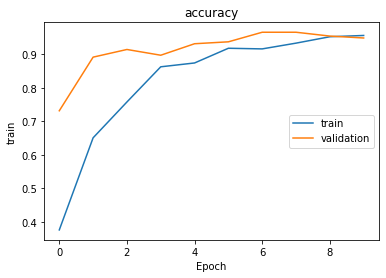

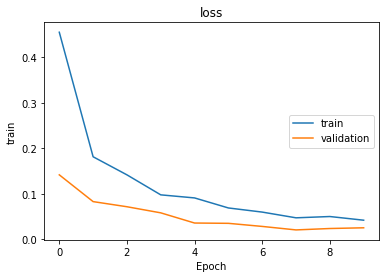

6/6 [==============================] - 5s 739ms/step - loss: 0.0249 - accuracy: 0.9486


In [14]:
"""
顯示訓練過程
"""
def show_train_history(title, train_history, train, validation): 
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title(title)
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='center right')
    plt.savefig(title+'png')
    plt.show()

show_train_history('accuracy',train_history,'accuracy','val_accuracy')
show_train_history('loss',train_history,'loss','val_loss')

model.save('/kaggle/working/Section_classify.h5') #儲存模型

scores = model.evaluate(x_test, y_test) #查看結果